In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import tensorflow as tf
from keras.layers import Input, Dense,UpSampling2D,AveragePooling2D, Activation, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten, concatenate

from keras.layers import concatenate, multiply
from keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet201

train_path = '/kaggle/input/trashnet/dataset-resized'

def preprocess_image(image):
    # Adjust brightness
    brightness = np.random.uniform(0.8, 1.2)  # Random brightness factor
    image = cv2.convertScaleAbs(image, alpha=brightness)

    # Adjust contrast
    contrast = np.random.uniform(0.7, 1.3)  # Random contrast factor
    image = cv2.convertScaleAbs(image, alpha=contrast, beta=0)  # beta is added for brightness adjustment

    # Adjust saturation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 1] = hsv[..., 1] * np.random.uniform(0.8, 1.2)  # Adjust saturation
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Adjust hue
    hue = np.random.randint(-4, 4)  # Random hue adjustment
    hsv[..., 0] = (hsv[..., 0] + hue) % 180
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Adjust exposure (simulated using gamma correction)
    gamma = np.random.uniform(0.7, 1.3)  # Random gamma value
    image = np.power(image / 255.0, gamma) * 255.0
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Adjust sharpness
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    return image

def load_dataset(path, target_shape):
    class_folders = os.listdir(path)
    filenames = []
    labels = []

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # Skip non-image files
                # Preprocess the image for lighting conditions
                processed_image = preprocess_image(image)
                resized_image = cv2.resize(processed_image, target_shape[:2])
                filenames.append(resized_image)
                labels.append(i)
            except Exception as e:
                print(f"Error processing image: {image_path} - {e}")

    X = np.array(filenames)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    y = np_utils.to_categorical(y)

    return X, y


# Define the target shape for resizing images
target_shape = (290, 290, 3)

# Load and preprocess the dataset
X, y = load_dataset(train_path, target_shape)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)

Shape of X_train, y_train: (1818, 290, 290, 3) (1818, 6)
Shape of X_test, y_test: (506, 290, 290, 3) (506, 6)
Shape of X_val, y_val: (203, 290, 290, 3) (203, 6)


In [3]:
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = GlobalAveragePooling2D()(input)
    se = Dense(filters // se_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

def create_parallel_cnn_model(input_shape, num_classes):
    MainInput = Input(shape=input_shape)
    dn169 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape, pooling=None)(MainInput)

    # Branch with MaxPooling and Squeeze-Excitation
    conv1 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(dn169)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(strides=(2, 2), padding="same")(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)
    conv1 = squeeze_excite_block(conv1, 256, 16)

    # Branch with AveragePooling and Squeeze-Excitation
    conv2 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(dn169)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = AveragePooling2D(pool_size=(2, 2), padding="same")(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = AveragePooling2D(pool_size=(2, 2), padding="same")(conv2)
    conv2 = squeeze_excite_block(conv2, 256, 16)

    # Global Average Pooling to reduce spatial dimensions to (1, 1)
    conv1 = tf.keras.layers.GlobalAveragePooling2D()(conv1)
    conv2 = tf.keras.layers.GlobalAveragePooling2D()(conv2)

    # Concatenate both branches
    merged = concatenate([conv1, conv2])

    # Dense layers
    dense1 = Dense(1024, activation="relu")(merged)
    dense2 = Dense(512, activation="relu")(dense1)
    output = Dense(num_classes, activation="softmax")(dense2)

    # Create the model
    model = Model(inputs=MainInput, outputs=output)

    return model

# Create the model
num_classes = y_train.shape[1]
model = create_parallel_cnn_model(target_shape, num_classes)
model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 290, 290, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, 9, 9, 1920)   18321984    ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 9, 9, 128)    12042368    ['densenet201[0][0]']            
                                                                                                  
 conv2d_4 (Conv2D)           

In [4]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=0.1), metrics=['accuracy'])

# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.001)

# Record the start time
import time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                          epochs=40,
                          batch_size=10,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint, early_stopping])

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_time))

Epoch 1/40
182/182 [==============================] - 83s 289ms/step - loss: 1.4495 - accuracy: 0.5154 - val_loss: 1.0504 - val_accuracy: 0.6010
Epoch 2/40
182/182 [==============================] - 41s 227ms/step - loss: 0.6994 - accuracy: 0.7789 - val_loss: 0.7953 - val_accuracy: 0.7488
Epoch 3/40
182/182 [==============================] - 41s 227ms/step - loss: 0.3554 - accuracy: 0.8927 - val_loss: 0.6053 - val_accuracy: 0.8177
Epoch 4/40
182/182 [==============================] - 41s 227ms/step - loss: 0.2542 - accuracy: 0.9180 - val_loss: 0.3435 - val_accuracy: 0.8867
Epoch 5/40
182/182 [==============================] - 40s 221ms/step - loss: 0.1590 - accuracy: 0.9510 - val_loss: 1.0697 - val_accuracy: 0.6305
Epoch 6/40
182/182 [==============================] - 40s 221ms/step - loss: 0.1453 - accuracy: 0.9521 - val_loss: 0.4698 - val_accuracy: 0.8818
Epoch 7/40
182/182 [==============================] - 40s 220ms/step - loss: 0.1303 - accuracy: 0.9637 - val_loss: 0.5708 - val_ac

Number of epochs trained: 40
Test loss: 0.25451815128326416
Test accuracy: 0.9328063130378723


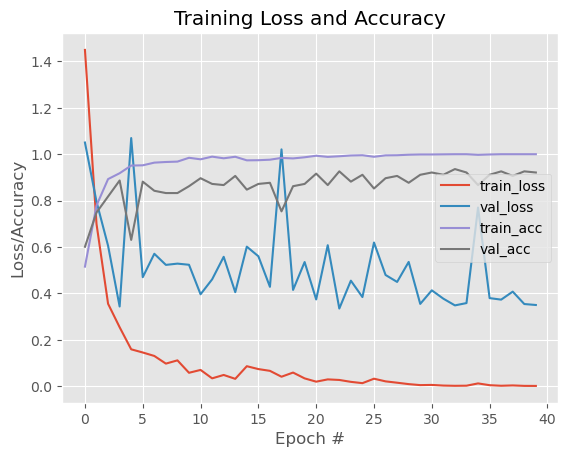

In [5]:
# Load the best weights
model.load_weights('/kaggle/working/model.h5')

# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("parallelCNN_Model")

# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

In [6]:
from sklearn.metrics import classification_report

# Define class labels
class_labels = ['Cardboard', 'Glass', 'Paper', 'Trash', 'Metal', 'Plastic']

# Make predictions on the test set

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate a classification report with specified target names
report = classification_report(y_test_labels, y_pred, target_names=class_labels)
print(report)

16/16 [==============================] - 5s 142ms/step
              precision    recall  f1-score   support

   Cardboard       0.93      0.95      0.94        73
       Glass       0.93      0.95      0.94       106
       Paper       0.95      0.93      0.94       122
       Trash       0.89      0.83      0.86        30
       Metal       0.95      0.96      0.96        82
     Plastic       0.91      0.90      0.91        93

    accuracy                           0.93       506
   macro avg       0.93      0.92      0.92       506
weighted avg       0.93      0.93      0.93       506



Number of epochs trained: 40


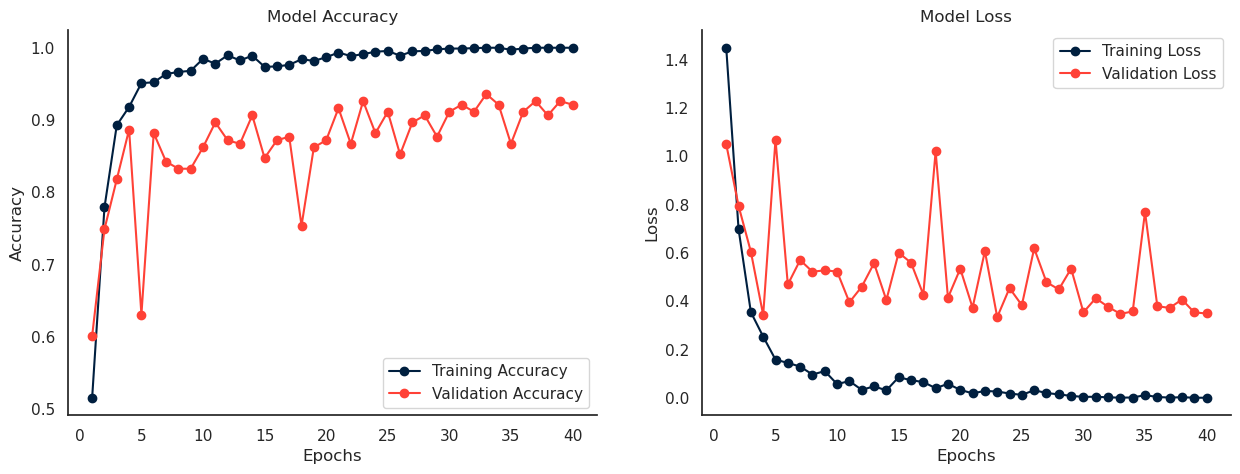

In [7]:
import seaborn as sns
# Set a seaborn style without grid lines
sns.set(style="white", rc={"axes.grid": False})

# Determine the number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# Define custom colors
training_color = '#001f3f'  # dark blue color
validation_color = '#FF4136'  # dark red color

# Plotting training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plotting accuracy
axes[0].plot(range(1, num_epochs_trained + 1), history.history['accuracy'], 'o-', color=training_color, label='Training Accuracy')
axes[0].plot(range(1, num_epochs_trained + 1), history.history['val_accuracy'], 'o-', color=validation_color, label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")

# Plotting loss
axes[1].plot(range(1, num_epochs_trained + 1), history.history['loss'], 'o-', color=training_color, label='Training Loss')
axes[1].plot(range(1, num_epochs_trained + 1), history.history['val_loss'], 'o-', color=validation_color, label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

# Beautify the plots
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Save the figure as a PDF
plt.savefig('journal_training_plot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


16/16 [==============================] - 2s 140ms/step


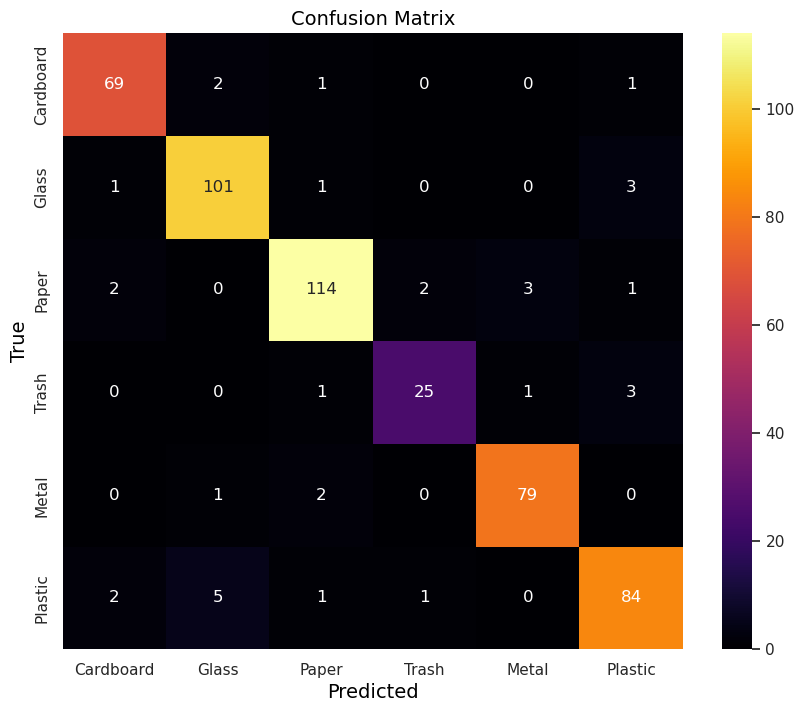

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ...

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get class labels in the desired order
#class_labels = ['Metal', 'White Glass', 'Biological', 'Paper', 'Brown Glass', 'Battery', 'Trash', 'Cardboard', 'Shoes', 'Clothes', 'Plastic', 'Green Glass']
class_labels = ['Cardboard', 'Glass', 'Paper', 'Trash', 'Metal', 'Plastic']


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='inferno',xticklabels=class_labels, yticklabels=class_labels)

# Customize the font properties for labels and title
title_font = {'fontname': 'Times New Roman', 'size': '14', 'color': 'black', 'weight': 'normal'}
plt.xlabel('Predicted', **title_font)
plt.ylabel('True', **title_font)
plt.title('Confusion Matrix', **title_font)

# Save the confusion matrix plot as a PDF file
plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


16/16 [==============================] - 2s 141ms/step


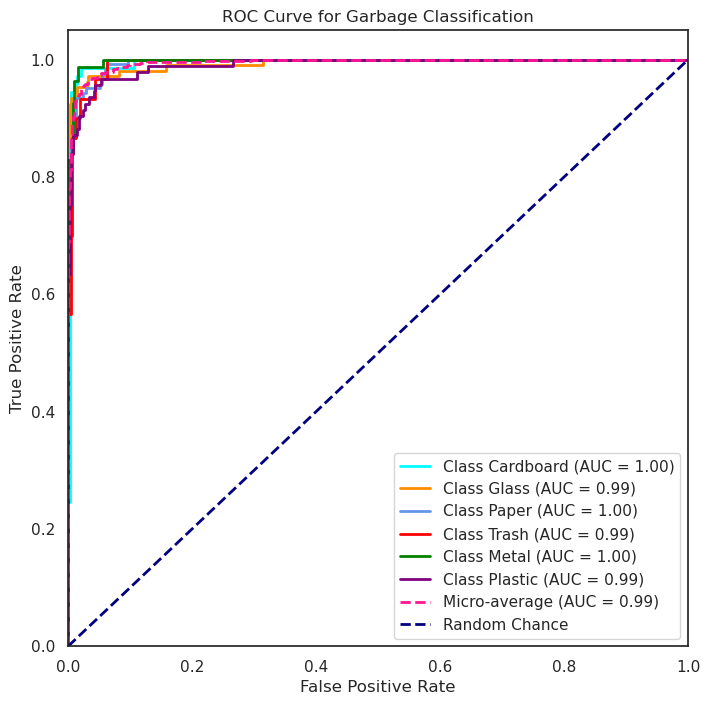

In [9]:
# Import necessary modules
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_score = model.predict(X_test)

# Binarize the true labels
y_test_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, linestyle='--', label=f'Micro-average (AUC = {roc_auc["micro"]:0.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Garbage Classification')
plt.legend(loc="lower right")

# Save the figure as a PDF
plt.savefig('roc_curve_plot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [10]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Evaluate the model on the test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(y_true, y_pred_classes)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

# Calculate Cohen's kappa score
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f'Cohen\'s Kappa Score: {kappa:.4f}')


Matthews Correlation Coefficient (MCC): 0.9174
Cohen's Kappa Score: 0.9174


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred_classes)
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1_score = f1_score(y_true, y_pred_classes, average='weighted')

# Calculate specificity
overall_specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall Specificity: {overall_specificity:.4f}')
print(f'Overall F1 Score: {overall_f1_score:.4f}')


Overall Accuracy: 0.9328
Overall Precision: 0.9327
Overall Recall: 0.9328
Overall Specificity: 0.9328
Overall F1 Score: 0.9326


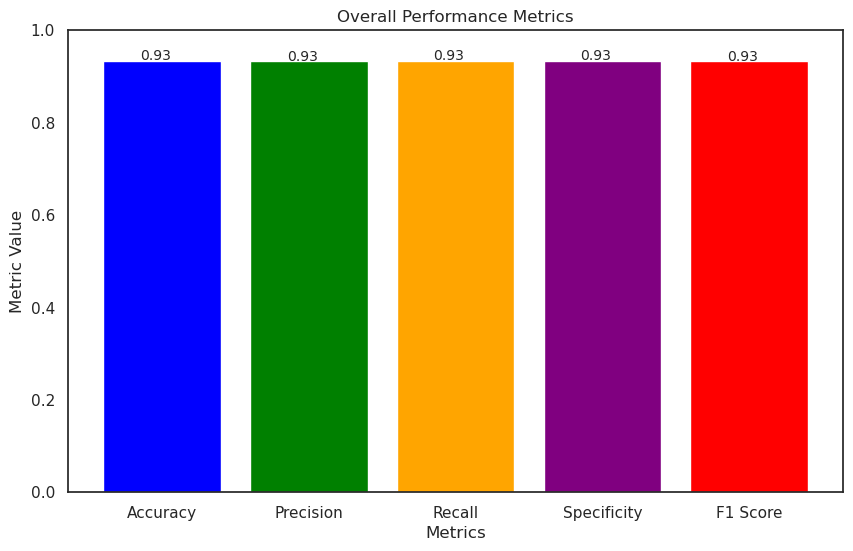

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred_classes)
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1_score = f1_score(y_true, y_pred_classes, average='weighted')

# Calculate specificity
overall_specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Plotting
metrics_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
metrics_values = [overall_accuracy, overall_precision, overall_recall, overall_specificity, overall_f1_score]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'purple', 'red'])

# Add values above the bars
for bar, value in zip(bars, metrics_values):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.002, f'{value:.2f}', fontsize=10)

# Set plot title and labels
plt.title('Overall Performance Metrics')
plt.ylabel('Metric Value')
plt.ylim([0, 1])  # Adjust the y-axis limits if necessary

# Add x-axis title
plt.xlabel('Metrics')

# Save the plot as a PDF file
plt.savefig('overall_metrics_plot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


